
# Spotify Sequential Skip Prediction Challenge

### Anna Martignano, Daniele Montesi, ID2223
With  this  project  we  would  like  to  use  Deep  Learning  to  model  a  solution  to  the  challenge  ”  Spotify Sequential  Skip  Prediction  Challenge  -  Predict  if  users  will  skip  or  listen  to  the  music  they’re  streamed” published by Spotify in collaboration with WSDM and CrowdAI.

Citing the CrowdAI Challenge Website:The task is to predict whether individual tracks encountered in a listening session will beskippedby a particular user.  In order to do this, complete information about the first half of a user’slistening session is provided, while the prediction is to be carried out on the second half.  

The output of a prediction is abinary variable for each track in the second half of the session indicating if it was skipped or not, with a 1 indicating that the track skipped, and a 0 indicating that the track was not skipped.The  problem  corresponds  hence  to  a  binary  classification.   However,  the  problem  is  hard  and  must take into account all the history of the user tracks listened, making the model that best fits this problem aRecurrent Neural Networks.


### Code organization


The problem will present the following sections:

1. Data exploration 
2. Data filtering/preprocessing 
3. Dataset creation
4. Model reasoning and creation and fitting (First Baseline)
5. Re-Implementation of the 5th solution
6. Further model improvement


## 0 - Libraries import and useful paths

In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers, utils, Model, Input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json, load_model

from pickle import dump
import pickle
from tqdm import tqdm
import string
import numpy as np
import random
from PIL import Image
import time
import os
import pandas as pd
from glob import glob
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold, KFold

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dirpath = "/content/drive/My Drive/Colab Notebooks/Project"
modelpath = dirpath + "/Model"
datapath = dirpath + "/Dataset"
processedpath = dirpath + "/ProcessedDataset"
testpath = datapath + "/test_set"
trainpath = datapath + "/training_set"
featurespath = datapath + "/track_features"

print(featurespath)

/content/drive/My Drive/Colab Notebooks/Project/Dataset/track_features


# 4- Loading the already preprocessed dataset

We have preprocessed both the dataset TRAIN and TEST. 
We here load it from the files.

Note: We need to use a modified versoin of no_load and restore the normal one, that's why we save a declaration of the old np_load before overriding it.

In [0]:
import numpy as np
# save np.load
np_load_old = np.load

In [0]:
# Load Training set
np.load = np_load_old

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

restored = np.load(processedpath + "/train.npz")
train_history = restored['history_train']
train_future = restored['future_train']
train_labels = restored['labels_train']
train_session_len = restored['session_len_train']

del restored

# restore np.load for future normal usage
np.load = np_load_old

In [0]:
# Load Test Set

np.load = np_load_old
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

restored2 = np.load(processedpath + "/test.npz")
test_history = restored2['history_test']
test_future = restored2['future_test']
test_session_len = restored2['session_len_test']

del restored2

# restore np.load for future normal usage
np.load = np_load_old

# 5- Model Fitting ad Evaluation Metrics 

To evaluate the performance of our solution we are going to use the same metrics proposed for this competition. 

The primary one is the **Mean Average Precision**:

\begin{equation*}
AA   =  \sum_{i=1}^{T} \frac{A(i)L(i)}{T}
\end{equation*}

The metric aims to weight higher the correct good prediction:


- T is the number of tracks to be predicted for the given session
- A(i) is the accuracy at position i of the sequence
- L(i) is the boolean indicator for if the i‘th prediction was correct

Gives high scores whether the first predicted labels are correct. Weights over all the sequences of predicted tracks starting from the beginning, till the end.

e.g. 
MAP([1,0,1,1,0,1])
  -> AA([1])\
  -> AA([1,0])\
  -> AA([1,0,1])\
  -> AA([1,0,1,1])\
  -> AA([1,0,1,1,0])\
  -> AA([1,0,1,1,0,1])

Moreover, we are going to use the **First Prediction Accuracy** for the second half of the dataset's track


In [0]:
def evaluation_MAP_FPA(sizes, label_matrix, prediction_matrix):
    '''
    Return MAP and first-prediction-accuracy
    :param sizes:    A list of session sizes
    :param labels:      The correct labels list [ [1,0,1,1,0,... size_of_truth_labels], ...]
    :param predictions: The predicted labels list [ [1,0,1,0,0,... size_of_predicted_labels], ...]
    :returns:           Mean Average Precision and First Prediction Accuracy
    '''
    # Set variables
    score = 0.0
    first_acc = 0.0
    # For every session
    for size, label_row, prediction_row in zip(sizes, label_matrix, prediction_matrix):
        # Set variables
        n_correct    = 0
        session      = 0.0
        # For the first 'size' predictions
        for i in range(size):        
            # If the prediction is correct:
            if label_row[i] == prediction_row[i]:
                # Increase counter of correct predictions
                n_correct += 1
                session += n_correct / (i + 1)
                # If first prediction
                if i == 0:
                    first_acc += 1
        # Save session score
        score += session / size
    return score/sizes.shape[0], first_acc/sizes.shape[0]


## Model Description

**RNN architecture:** 
- to capture the time-correlation among data input **LSTM layers** are used to model the input sequences.
Instead, dense layers are connected to future input tracks, the ones needed to be predicted.

- Input sequences are modelled using doubly
the outputs of these LSTM and dense layers are concatenated and fed into the tail of the network. 

- All dense layers are followed by
exponential linear units (ELUs).

**Avoid overfitting:** 
- **dropout** is applied, and as well **batch normalization **to allow more effective weights updates. When training, 
- we have also adopted **early stopping**, when the results do not improve for 5 epochs consecutively the best weights are 

**Personalization of the loss measure:** 
since the challenge gives more importance to the accuracy of the prediction of the first tracks in the session, we have opt to use a weighted variant of binary cross-entropy as loss function.

**Optimization of the training procedure**
We decided to employ Adam optimization which combines RMSProp(weighte version of the Adagrad optimization on the lr) and Momentum updates.
Adam has amsgrad, in orer to apply the AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and Beyond".

Declared are the parameter of the best tuned model.



In [0]:
from tensorflow.keras import losses
from tensorflow.keras.utils import plot_model

def generate_model(history, future, dropout_1=.35, dropout_2=.35, dropout_3=.25, lr= 0.001, amsgrad=True):
    h_input  = tf.keras.layers.Input(shape = (history.shape[1], history.shape[2]))
    h_subnet = tf.keras.layers.Dropout(dropout_1)(h_input)
    h_subnet = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences = True)(h_subnet)
    h_subnet = tf.compat.v1.keras.layers.CuDNNLSTM(256)(h_subnet)

    f_input  = tf.keras.layers.Input(shape = (future.shape[1], future.shape[2]))
    f_subnet = tf.keras.layers.Dropout(dropout_2)(f_input)
    f_subnet = tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences = True)(f_subnet)
    f_subnet = tf.compat.v1.keras.layers.CuDNNLSTM(128)(f_subnet)

    td_subnet = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32))(f_input)
    td_subnet = tf.keras.layers.Flatten()(td_subnet)

    concat = tf.keras.layers.concatenate([h_subnet, f_subnet, td_subnet])
    concat = tf.keras.layers.Dropout(dropout_3)(concat)

    dense1  = tf.keras.layers.Dense(512, activation = 'elu')(concat)
    dense1  = tf.keras.layers.BatchNormalization()(dense1)
    dense2  = tf.keras.layers.Dense(512, activation = 'elu')(dense1)

    outputs = [tf.keras.layers.Dense(1, activation = 'sigmoid')(dense2) for _ in range(10)]

    model = tf.keras.Model(inputs = [h_input, f_input], outputs = outputs)
    model.compile(loss='binary_crossentropy',
                                   optimizer = tf.keras.optimizers.Adam(lr = lr, amsgrad = amsgrad),
                                   metrics=['accuracy'],
                                   loss_weights = weights.tolist())
    
    return model

# The model architecture

2 Inputes:
- History Session & Tracks features (2x2) x num of batch samples

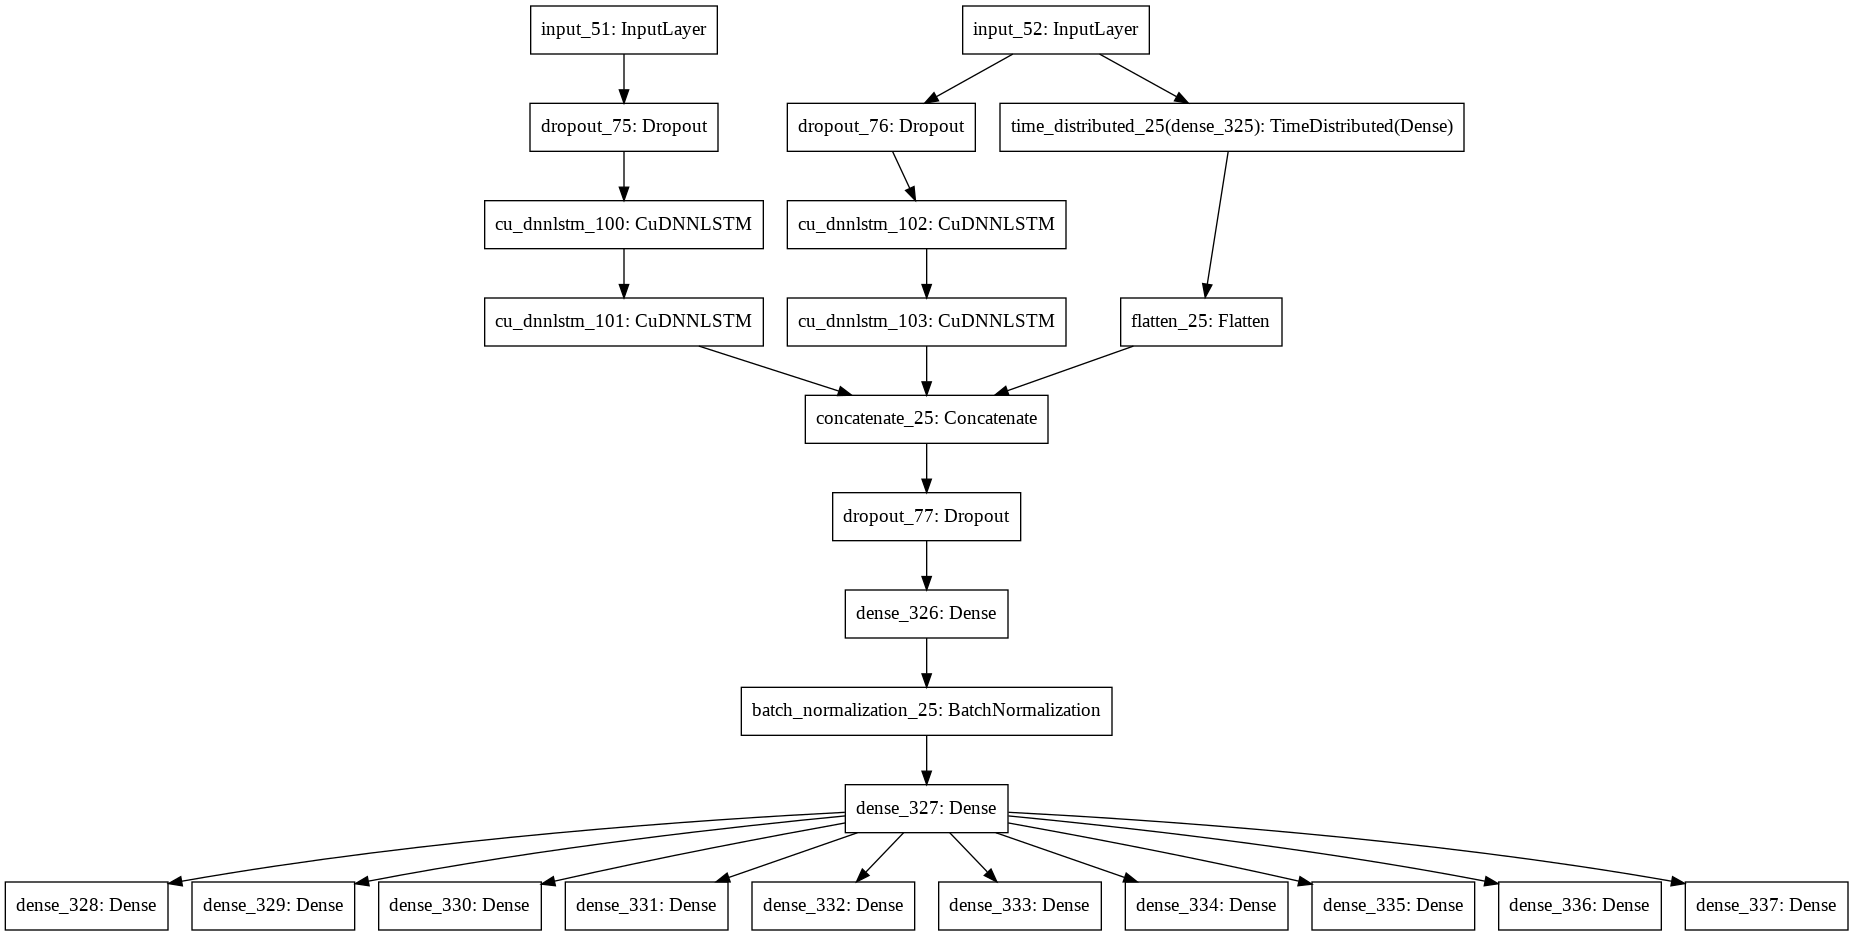

In [34]:
model = generate_model(train_history, train_future)
plot_model(model)

# Validation on hyperparameters



In [0]:
from tensorflow.keras import layers, utils, Model, Input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout

# k-fold Cross-validation grouped on sessions
k = 3
n_epochs = 2
param_config_list = [{'dropout_1': 0.2, 'dropout_2':.2, 'dropout_3':.2, 'lr': 0.001, 'amsgrad':True},
                     {'dropout_1': 0.3, 'dropout_2':.3, 'dropout_3':.3, 'lr': 0.001, 'amsgrad':True},
                     {'dropout_1': 0.4, 'dropout_2':.4, 'dropout_3':.4, 'lr': 0.001, 'amsgrad':True},
                     {'dropout_1': 0.35, 'dropout_2':.35, 'dropout_3':.35, 'lr': 0.001, 'amsgrad':True},
                     {'dropout_1': 0.35, 'dropout_2':.35, 'dropout_3':.45, 'lr': 0.001, 'amsgrad':True},
                     {'dropout_1': 0.35, 'dropout_2':.35, 'dropout_3':.25, 'lr': 0.1, 'amsgrad':True},
                     {'dropout_1': 0.35, 'dropout_2':.35, 'dropout_3':.25, 'lr': 0.01, 'amsgrad':True},
                     {'dropout_1': 0.35, 'dropout_2':.35, 'dropout_3':.25, 'lr': 0.001, 'amsgrad':True},
                     {'dropout_1': 0.35, 'dropout_2':.35, 'dropout_3':.25, 'lr': 0.005, 'amsgrad':True},
                     {'dropout_1': 0.25, 'dropout_2':.35, 'dropout_3':.25, 'lr': 0.001, 'amsgrad':True},
                     ]
# List for the results on the configurations
res_map = []
for conf in param_config_list:
  test_predictions = []
  all_maps = []

  print('=========================================================')
  print('PARAMETERS CONFIG:', conf)
  print('=========================================================')

  # Generate model
  
  # Loss weights
  weights = np.asarray([(1 / val + sum((1 / (2*n)) for n in range(val + 1,11))) for val in range(1,11)])
  weights /= weights.max()
  model = generate_model(train_history, train_future, **conf)
  plot_model(model)
  for fold_id, (train_idx, valid_idx) in enumerate(KFold(n_splits = k).split(train_history)):
      print('{0}\t----- FOLD {1} -----'.format(datetime.datetime.now(),fold_id))
      # Filter out training and testing data
      h_train = train_history[train_idx]
      h_valid = train_history[valid_idx]
      f_train = train_future[train_idx]
      f_valid = train_future[valid_idx]
      l_train = train_labels[train_idx]
      l_valid = train_labels[valid_idx]
      s_train = train_session_len[train_idx]
      s_valid = train_session_len[valid_idx]

      # Loss weights
      weights = np.asarray([(1 / val + sum((1 / (2*n)) for n in range(val + 1,11))) for val in range(1,11)])
      weights /= weights.max()
      
      # Early stopping
      best_map = .0
      best_weights = None
      best_epoch = 0

      # For every epoch
      for epoch_id in range(n_epochs):
          model.fit([h_train, f_train], [l_train[:,i] for i in range(10)],
                    validation_data = ([h_valid, f_valid], [l_valid[:,i] for i in range(10)]),
                    batch_size = 2048, epochs = 1, verbose = 2)
          p_valid = model.predict([h_valid, f_valid], batch_size = 4096)
          MAP, FPA = evaluation_MAP_FPA(s_valid, l_valid, np.swapaxes(np.round(p_valid),0,1))
          print('{0}\t\tValid\tMAP:\t{1}\tFPA:\t{2}'.format(datetime.datetime.now(),MAP, FPA))
          if MAP > best_map:
              best_map = MAP
              best_epoch = epoch_id
              best_weights = model.get_weights()
              model.save_weights(modelpath + '/model_weights_epoch_{}.h5'.format(epoch_id+1))
          elif epoch_id - best_epoch >= 5:
              break

          print('{0}\t\tStopping at epoch {1}, best epoch was {2} with MAP {3}'.format(datetime.datetime.now(),epoch_id, best_epoch, best_map))

          all_maps.append(best_map)

          print('{0}\t\tPredicting for test set...'.format(datetime.datetime.now()))
          # Reload best weights
          model.set_weights(best_weights)

          # Predict for test set
          p_test = model.predict([test_history, test_future], batch_size = 4096)
          test_predictions.append(np.swapaxes(p_test,0,1))
      print('=========================================================')
      print('{0}\t\tAverage best MAP over all folds:\t\t{1}...'.format(datetime.datetime.now(), np.mean(all_maps)))
      print('=========================================================')
      #print('{0}\t\tGenerating submission...'.format(datetime.datetime.now()))
      # Geometric mean of predictions over folds
      p_test = np.prod(test_predictions, axis = 0) ** (1.0 / len(test_predictions))
      
  res_map = res_map+[np.mean(all_maps)]

PARAMETERS CONFIG: {'dropout_1': 0.2, 'dropout_2': 0.2, 'dropout_3': 0.2, 'lr': 0.001, 'amsgrad': True}
2020-01-12 15:12:25.811698	----- FOLD 0 -----
Train on 118894 samples, validate on 59448 samples
118894/118894 - 10s - loss: 2.0731 - dense_185_loss: 0.6140 - dense_186_loss: 0.6603 - dense_187_loss: 0.6736 - dense_188_loss: 0.6704 - dense_189_loss: 0.6678 - dense_190_loss: 0.6298 - dense_191_loss: 0.5578 - dense_192_loss: 0.5057 - dense_193_loss: 0.4679 - dense_194_loss: 0.4605 - dense_185_accuracy: 0.6789 - dense_186_accuracy: 0.6329 - dense_187_accuracy: 0.6140 - dense_188_accuracy: 0.6045 - dense_189_accuracy: 0.6174 - dense_190_accuracy: 0.6503 - dense_191_accuracy: 0.6946 - dense_192_accuracy: 0.7262 - dense_193_accuracy: 0.7456 - dense_194_accuracy: 0.7469 - val_loss: 1.9815 - val_dense_185_loss: 0.5421 - val_dense_186_loss: 0.6132 - val_dense_187_loss: 0.6346 - val_dense_188_loss: 0.6494 - val_dense_189_loss: 0.6490 - val_dense_190_loss: 0.6619 - val_dense_191_loss: 0.6717 - 

In [0]:
best_config = np.argmax(res_map)
print("Best config found is:", param_config_list[best_config])

Best config found is: {'dropout_1': 0.35, 'dropout_2': 0.35, 'dropout_3': 0.25, 'lr': 0.001, 'amsgrad': True}


# Training:

Training implemented using 5-fold cross-validation with **early stopping**, when the results do not improve for 5 epochs consecutively the best weights are saved

In [0]:
from tensorflow.keras import layers, utils, Model, Input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout

# k-fold Cross-validation grouped on sessions
k = 5
n_epochs = 50
test_predictions = []
all_maps = []

# Generate model
model = generate_model(train_history, train_future)
plot_model(model)
for fold_id, (train_idx, valid_idx) in enumerate(KFold(n_splits = k).split(train_history)):
    print('{0}\t----- FOLD {1} -----'.format(datetime.datetime.now(),fold_id))
    # Filter out training and testing data
    h_train = train_history[train_idx]
    h_valid = train_history[valid_idx]
    f_train = train_future[train_idx]
    f_valid = train_future[valid_idx]
    l_train = train_labels[train_idx]
    l_valid = train_labels[valid_idx]
    s_train = train_session_len[train_idx]
    s_valid = train_session_len[valid_idx]

    # Loss weights
    weights = np.asarray([(1 / val + sum((1 / (2*n)) for n in range(val + 1,11))) for val in range(1,11)])
    weights /= weights.max()
    
    # Early stopping
    best_map = .0
    best_weights = None
    best_epoch = 0

    # For every epoch
    for epoch_id in range(n_epochs):
        model.fit([h_train, f_train], [l_train[:,i] for i in range(10)],
                  validation_data = ([h_valid, f_valid], [l_valid[:,i] for i in range(10)]),
                  batch_size = 2048, epochs = 1, verbose = 2)
        p_valid = model.predict([h_valid, f_valid], batch_size = 4096)
        MAP, FPA = evaluation_MAP_FPA(s_valid, l_valid, np.swapaxes(np.round(p_valid),0,1))
        print('{0}\t\tValid\tMAP:\t{1}\tFPA:\t{2}'.format(datetime.datetime.now(),MAP, FPA))
        if MAP > best_map:
            best_map = MAP
            best_epoch = epoch_id
            best_weights = model.get_weights()
            model.save_weights(modelpath + '/model_weights_epoch_{}.h5'.format(epoch_id+1))
        elif epoch_id - best_epoch >= 5:
            break

        print('=========================================================')
        print('{0}\t\tStopping at epoch {1}, best epoch was {2} with MAP {3}'.format(datetime.datetime.now(),epoch_id, best_epoch, best_map))
        print('=========================================================')
        all_maps.append(best_map)

        print('{0}\t\tPredicting for test set...'.format(datetime.datetime.now()))
        # Reload best weights
        model.set_weights(best_weights)

    # Predict for test set
    p_test = model.predict([test_history, test_future], batch_size = 4096)
    test_predictions.append(np.swapaxes(p_test,0,1))

    print('=========================================================')
    print('{0}\t\tAverage best MAP over all folds:\t\t{1}...'.format(datetime.datetime.now(), np.mean(all_maps)))
    print('=========================================================')
    #print('{0}\t\tGenerating submission...'.format(datetime.datetime.now()))
    # Geometric mean of predictions over folds
    p_test = np.prod(test_predictions, axis = 0) ** (1.0 / len(test_predictions))

2020-01-10 18:25:16.109007	----- FOLD 0 -----
Train on 142673 samples, validate on 35669 samples
142673/142673 - 9s - loss: 2.0943 - dense_133_loss: 0.6390 - dense_134_loss: 0.6540 - dense_135_loss: 0.6823 - dense_136_loss: 0.6777 - dense_137_loss: 0.6681 - dense_138_loss: 0.6288 - dense_139_loss: 0.5521 - dense_140_loss: 0.4942 - dense_141_loss: 0.4529 - dense_142_loss: 0.4287 - dense_133_acc: 0.6648 - dense_134_acc: 0.6322 - dense_135_acc: 0.6088 - dense_136_acc: 0.5994 - dense_137_acc: 0.6142 - dense_138_acc: 0.6532 - dense_139_acc: 0.6999 - dense_140_acc: 0.7298 - dense_141_acc: 0.7493 - dense_142_acc: 0.7590 - val_loss: 1.9587 - val_dense_133_loss: 0.5583 - val_dense_134_loss: 0.6085 - val_dense_135_loss: 0.6269 - val_dense_136_loss: 0.6387 - val_dense_137_loss: 0.6554 - val_dense_138_loss: 0.6160 - val_dense_139_loss: 0.5795 - val_dense_140_loss: 0.5294 - val_dense_141_loss: 0.5013 - val_dense_142_loss: 0.5546 - val_dense_133_acc: 0.7295 - val_dense_134_acc: 0.6810 - val_dense_13

# Test set Evaluation

According to the 5-fold cross validation, we have found that the best epochs are 14.

We go to load the model saved at these epochs and perform the evaluation on the test set_

In [0]:
#Import the model with the highest performances
best_epochs = 14

weights = np.asarray([(1 / val + sum((1 / (2*n)) for n in range(val + 1,11))) for val in range(1,11)])
weights /= weights.max()

new_model = generate_model(test_history, test_future)
new_model.load_weights(modelpath + '/model_weights_epoch_{}.h5'.format(best_epochs))
new_model.compile(loss='binary_crossentropy',
                                   optimizer = tf.keras.optimizers.Adam(lr = 0.002, amsgrad = True),
                                   metrics=['accuracy'])


In [0]:
prediction = new_model.predict([test_history, test_future], batch_size = 4096)
MAP, FPA = evaluation_MAP_FPA(train_session_len, train_labels, np.swapaxes(np.round(prediction),0,1))

In [0]:
print("Performances--> MAP: {} | FPA: {}".format(MAP,FPA))

Performances--> MAP: 0.5793433557729396 | FPA: 0.7734857745231073


### Not bad!

With only few samples from the dataset and a good model we are able to perform a score similar to **~10th position** of the rank in the global Leaderboard!

# 6- Feature engineered dataset: New training & predictions

# First see Notebook 4

We hereby show the results over a feature-engineered dataset (Notebook of the preprocessing over Features)

We can observe that the dataset we employed is quite small (applying the feature engineering function required too much time, so we used a subset of the training samples), hence different results are expected and not comparable over the ones obtained before. 

Recurrent networks have lots of parameters due to the LSTM gates and layers created by the sequences, that is expecte that the performance of the model won't be as good as the other.

In [0]:
import numpy as np
# save np.load
np_load_old = np.load

In [0]:
np.load = np_load_old

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


restored = np.load(processedpath + "/trainfeatures.npz")
train_history = restored['history_train']
train_future = restored['future_train']
train_labels = restored['labels_train']
train_session_len = restored['session_len_train']

del restored

# restore np.load for future normal usage
np.load = np_load_old

In [0]:
np.load = np_load_old
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

restored2 = np.load(processedpath + "/testfeatures.npz")
test_history = restored2['history_test']
test_future = restored2['future_test']
test_session_len = restored2['session_len_test']

del restored2

# restore np.load for future normal usage
np.load = np_load_old

In [0]:
from tensorflow.keras import layers, utils, Model, Input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout

# k-fold Cross-validation grouped on sessions
k = 5
n_epochs = 50
test_predictions = []
all_maps = []

# Generate model
model = generate_model(train_history, train_future)
plot_model(model)
for fold_id, (train_idx, valid_idx) in enumerate(KFold(n_splits = k).split(train_history)):
    print('{0}\t----- FOLD {1} -----'.format(datetime.datetime.now(),fold_id))
    # Filter out training and testing data
    h_train = train_history[train_idx]
    h_valid = train_history[valid_idx]
    f_train = train_future[train_idx]
    f_valid = train_future[valid_idx]
    l_train = train_labels[train_idx]
    l_valid = train_labels[valid_idx]
    s_train = train_session_len[train_idx]
    s_valid = train_session_len[valid_idx]

    # Loss weights
    weights = np.asarray([(1 / val + sum((1 / (2*n)) for n in range(val + 1,11))) for val in range(1,11)])
    weights /= weights.max()
    
    # Early stopping
    best_map = .0
    best_weights = None
    best_epoch = 0

    # For every epoch
    for epoch_id in range(n_epochs):
        model.fit([h_train, f_train], [l_train[:,i] for i in range(10)],
                  validation_data = ([h_valid, f_valid], [l_valid[:,i] for i in range(10)]),
                  batch_size = 2048, epochs = 1, verbose = 2)
        p_valid = model.predict([h_valid, f_valid], batch_size = 4096)
        MAP, FPA = evaluation_MAP_FPA(s_valid, l_valid, np.swapaxes(np.round(p_valid),0,1))
        print('{0}\t\tValid\tMAP:\t{1}\tFPA:\t{2}'.format(datetime.datetime.now(),MAP, FPA))
        if MAP > best_map:
            best_map = MAP
            best_epoch = epoch_id
            best_weights = model.get_weights()
            model.save_weights(modelpath + '/model_weights_epoch_{}.h5'.format(epoch_id+1))
        elif epoch_id - best_epoch >= 5:
            break

        print('=========================================================')
        print('{0}\t\tStopping at epoch {1}, best epoch was {2} with MAP {3}'.format(datetime.datetime.now(),epoch_id, best_epoch, best_map))
        print('=========================================================')
        all_maps.append(best_map)

        print('{0}\t\tPredicting for test set...'.format(datetime.datetime.now()))
        # Reload best weights
        model.set_weights(best_weights)

    # Predict for test set
    p_test = model.predict([test_history, test_future], batch_size = 4096)
    test_predictions.append(np.swapaxes(p_test,0,1))

    print('=========================================================')
    print('{0}\t\tAverage best MAP over all folds:\t\t{1}...'.format(datetime.datetime.now(), np.mean(all_maps)))
    print('=========================================================')
    #print('{0}\t\tGenerating submission...'.format(datetime.datetime.now()))
    # Geometric mean of predictions over folds
    p_test = np.prod(test_predictions, axis = 0) ** (1.0 / len(test_predictions))

2020-01-12 15:41:18.758594	----- FOLD 0 -----
Train on 7147 samples, validate on 1787 samples
7147/7147 - 19s - loss: 2.9475 - dense_315_loss: 0.9729 - dense_316_loss: 0.7953 - dense_317_loss: 1.0846 - dense_318_loss: 0.8277 - dense_319_loss: 0.8086 - dense_320_loss: 0.7448 - dense_321_loss: 0.8592 - dense_322_loss: 0.6929 - dense_323_loss: 0.6997 - dense_324_loss: 0.6497 - dense_315_accuracy: 0.5054 - dense_316_accuracy: 0.5122 - dense_317_accuracy: 0.5136 - dense_318_accuracy: 0.5299 - dense_319_accuracy: 0.5426 - dense_320_accuracy: 0.5857 - dense_321_accuracy: 0.6088 - dense_322_accuracy: 0.6288 - dense_323_accuracy: 0.6078 - dense_324_accuracy: 0.6348 - val_loss: 2.5052 - val_dense_315_loss: 0.7437 - val_dense_316_loss: 0.6971 - val_dense_317_loss: 0.7591 - val_dense_318_loss: 0.7640 - val_dense_319_loss: 0.7225 - val_dense_320_loss: 0.7183 - val_dense_321_loss: 0.9924 - val_dense_322_loss: 1.0186 - val_dense_323_loss: 0.8600 - val_dense_324_loss: 0.7943 - val_dense_315_accuracy: 

We obtained a map of ~ 0.55, which is lower than the one obtained with the whole dataset, (as expected).



# 7- Future Steps
As future steps, we would like to:

- Perform the evaluation over a bigger dataset, possibly using some distirbuted computing techniques / parallel processing to speed-up the feature engineering paert
- Make an ensemble of the model with some other Machine Learning lcassifier (XGBoost was one of the most used together with RNN in the challenge!)
